In [1]:
def do_setup():
    # How to download competition data to temp folder(data) 
    # unzip it there, then symlink it like its a subdir
    # NOTE: make sure kaggle.json is in /root/.kaggle/

    #remove original symlink from this directory
    !rm ./data
    
    #remove old setup files
    !rm setup.sh

    #create temp holder
    !mkdir /root/data

    #symlink it
    !ln -s /root/data ./data

    #download competition data to temp data folder
    !cd ./data;kaggle competitions download -c paddy-disease-classification

    #unzip it, -q is silent
    !cd ./data;unzip -q paddy-disease-classification.zip

    #setup dotfiles
    !wget "https://raw.githubusercontent.com/CNUClasses/dotfiles/master/setup.sh";chmod 766 setup.sh;source ./setup.sh  
    
import os
if(not os.path.exists('./data/train_images')):
   !chmod 600 /root/.kaggle/kaggle.json
   do_setup()  

In [2]:
#install needed libraries
try: from path import Path
except ModuleNotFoundError:
    !pip install path --quiet
    from path import Path
try: import timm
except ModuleNotFoundError:
    !pip install timm --quiet
    import timm

## Functions, constants, imports

In [3]:
import os
def get_fls(pth, ext=['.png','.jpg']):
    '''
    pth: recursively gather all image files in pth
    return: list of files (with absolute paths)
    '''
    pth=os.path.abspath(pth)       #absolute path
    ext=[ext.lower() for ext in ext]  #make sure lowercase
    res=[]
    for root,dirs,fles in os.walk(pth):
        for fle in fles:
            if os.path.splitext(fle)[1].lower() in ext:
                res.append(os.path.join(root,fle))
    return res

model_name='resnet26d'
train_path='./data/train_images'   #get train and validation Datasets from here
test_path='./data/test_images'     #get test set from here
batch_size=32

In [31]:
import torch
import pandas as pd
import torch.optim as optim
from tqdm.auto import tqdm

## Define datasets, dataloader, model, and error function

### Get data

In [5]:
df =pd.read_csv('./data/train.csv')
df

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [6]:
#get a small dataset to train on
df=df.iloc[:200,:]

In [16]:
print(df.shape)
batch_size=4

(200, 4)


### Define Dataset

In [8]:
# #get a list of files
trn_val_files=get_fls(train_path)  
tst_files=get_fls(test_path) 
print(f'Len train={len(trn_val_files)}, length test={len(tst_files)}')

Len train=10407, length test=3469


In [9]:
import torch.nn as nn
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms

class MultiTaskDatasetTest(Dataset):
    '''
    Use for test dataset, all files are in img_dir, there is no other information associated with each file               
    '''
    def __init__(self,img_dir,*,transforms=None, target_transform=None):
        self.files=get_fls(img_dir)  #build a list of all the absolute path files
        self.transforms = transforms
        self.target_transform = target_transform  
     
    def __len__(self): return len(self.files)
        
    def __getitem__(self,idx):
        image=read_image(str(self.files[idx]))   #get the image    
        if self.transforms:
            image = self.transforms(image)      
        return image
    
# create a dict to map label strings to tensors
i_to_label=dict(enumerate(df.label.unique()))
label_to_i={v:i for i,v in i_to_label.items()}
#create another to map variety strings to tensors
i_to_variety=dict(enumerate(df.variety.unique()))
variety_to_i={v:i for i,v in i_to_variety.items()}
class MultiTaskDatasetTrain(Dataset): 
    '''
    Use for train and validation datasets, use when you know both the label and variety               
    '''
    def __init__(self,img_dir,*,df=None,transforms=None, target_transform=None):
        '''
        df: contains info to build train and validation datasets
        img_dir: where images are ex "./data/train_images"
        transforms: list of transforms to apply      
        '''
        super().__init__()
        self.image_ids=df.loc[:,'image_id'].tolist()
        self.labels=df.loc[:,'label'].tolist()
        self.varietys=df.loc[:,'variety'].tolist()
        self.files=[]
        for image_id,label in zip(self.image_ids, self.labels):
            self.files.append(os.path.join(img_dir,label,image_id))
        assert len(self.files)==len(self.labels) and len(self.files)==len(self.varietys), f"files,labels and variety must be same length"

        #now convert the labels and varieties to numbers
        self.labels=list(map(label_to_i.get,self.labels))
        self.varietys=list(map(variety_to_i.get,self.varietys))
 
        self.transforms = transforms
        self.target_transform = target_transform       
        # self.size = len(self.files)

    def __len__(self): return len(self.files)

    def __getitem__(self,idx):
        #dealing with the image
        image=read_image(str(self.files[idx]))
        
        lbl=self.labels[idx]
        variety=self.varietys[idx]
        
        if self.transforms:
            image = self.transforms(image)
        # img = PIL.Image.open(self.paths[idx]).convert('RGB')
        # img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        # img = img.apply_tfms(self.transform, size = self.size)
        # img = self.norm(img.data)
        
        return image,lbl,variety
    
    def display(self,idx):
        image,lbl,variety=self[idx]
        print(f'{self.i_to_label[lbl]}')
        print(f'{self.i_to_variety[variety]}')
        # from fastai.vision.all import *
        # img=PILImage.create(files[0])
        # print(img.size)
        # img.to_thumb(128)



In [10]:
import sklearn
from sklearn.model_selection import train_test_split
sklearn.__version__

'1.1.1'

### Train,Val and Test Datasets

#### Get train, val df by stratified split on df

In [11]:
#stratify dataframe by multiple columns (see Paddy-Multi.ipynb)
train, val = train_test_split(df, test_size=0.2, random_state=0, stratify=df[['label', 'variety']])
len(train) + len(val)

200

#### Get a list of transforms that the original model used

In [12]:
cfg=timm.data.resolve_data_config({}, model=model_name, verbose=True)
cfg

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

#### Create Datasets

In [13]:
import torchvision.transforms as transforms

image_size=cfg['input_size'][-2:] #get just the height and width (not the channels)
mean=cfg['mean'] #mean and std come from the model
std=cfg['std']

train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ConvertImageDtype(torch.float),
        # transforms.ToTensor(), #not needed if already a tensor
        transforms.Normalize(mean=mean,std=std)     #mean and std come from the model
    ])
val_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean,std=std)
])

trn_dataset = MultiTaskDatasetTrain(train_path,df=train,transforms=train_transforms) #use train df
val_dataset = MultiTaskDatasetTrain(train_path,df=val,transforms=val_transforms)   #use val df
test_dataset=MultiTaskDatasetTest(test_path, transforms=val_transforms)            #test set


print(f'Number train images={len(trn_dataset)}, number validation={len(val_dataset)}, and number test images={len(test_dataset)}')
assert(len(trn_dataset)+len(val_dataset)==len(trn_val_files))
assert(len(test_dataset)==len(tst_files))

Number train images=160, number validation=40, and number test images=3469


AssertionError: 

### Create DataLoaders

In [18]:
from torch.utils.data import DataLoader
trn_dl=DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True) #drop last to avoid crash
val_dl=DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)

#### Check on DataLoader

In [19]:
import matplotlib.pyplot as plt
imgs,lbls,varieties = next(iter(val_dl))
print(f"Feature batch shape: {imgs.size()}")
print(f"Labels batch shape: {lbls.size()}")
print(f"Varieties batch shape: {varieties.size()}")

Feature batch shape: torch.Size([4, 3, 224, 224])
Labels batch shape: torch.Size([4])
Varieties batch shape: torch.Size([4])


#### Show the images <mark> is this correct?

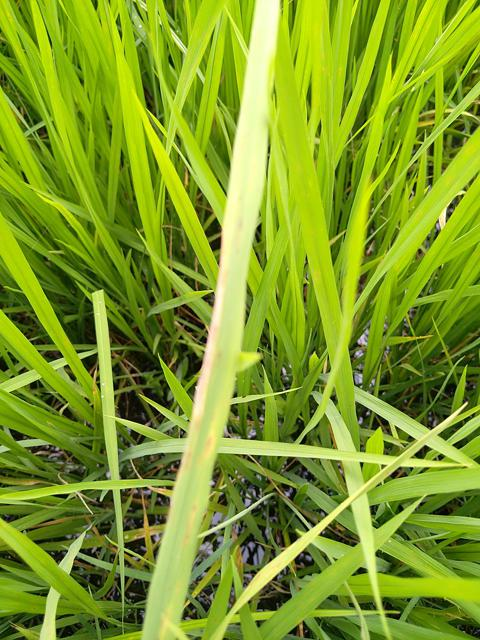

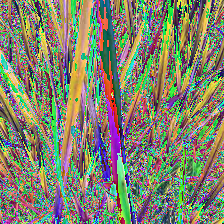

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: bacterial_leaf_blight
Variety: ADT45


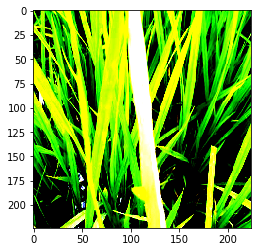

In [20]:
#look at original image and new one
from PIL import Image
import numpy as np
img1,lbl,variety = trn_dataset[0]

# original image (PIL)
Image.open(trn_dataset.files[0]).show()

#see returned as a PIL image
import torchvision.transforms as T
transform = T.ToPILImage()
transform(img1).show()

#show as raw tensor
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
show(img1)

print(f"Label: {i_to_label[lbl]}")
print(f"Variety: {i_to_variety[variety]}")

### Custom Loss function

In [21]:
class DiseaseAndTypeClassifierLoss(nn.Module):
    def __init__(self):
        super(DiseaseAndTypeClassifierLoss, self).__init__()

    def forward(self, pred_labels,pred_varieties, correct_labels,correct_varieties):
        #using crossentropy loss
        criterion = nn.CrossEntropyLoss()
        
        #get the preds
        # pred_labels=preds[0]
        # pred_varieties=preds[1]
        
        #get the actuals
        # correct_labels=labels[0]
        # correct_varieties=labels[1]
        
        # print(pred_labels)
        # print(pred_varieties) 
        # print(correct_labels)
        # print(correct_varieties)
        
        loss_labels= criterion(pred_labels, correct_labels)
        loss_varieties=criterion(pred_varieties, correct_varieties)
    
        return loss_labels , loss_varieties

### Error rate and Accuracy

In [22]:
def acc(preds,lbls):
    '''
    preds:[nxn] tensor
    lbls:[1xn] tensor
    sums number of lbl positions that are equivalent to max pred
    then divides by total number of samples
    returns: float between 0 and 1
    '''
    return ((torch.argmax(preds,dim=1)==lbls).sum()/len(lbls)).item()
def error_rate(preds,lbls):
    return(1-acc(preds,lbls))


### Define Multi Head Model (2 output params)

In [23]:
import torch.nn as nn
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self,tmodel):
        '''
        tmodel: pretrained model
        ex:
        model_name='resnet26d'
        tmodel=timm.create_model(model_name, pretrained=True)
        m1=DiseaseAndTypeClassifier(tmodel)
        
        '''
        super().__init__()
        self.m = tmodel
        self.m.fc=nn.Sequential(
            nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.4))
        # self.m.fc=nn.Linear(in_features=self.m.get_classifier().in_features,out_features=512, bias=False)
        self.l1=nn.Linear(in_features=512, out_features=10, bias=False)  #rice type
        self.l2=nn.Linear(in_features=512, out_features=10, bias=False)  #disease
        
    def forward(self,x):       
        x=self.m(x)
        label=self.l1(x)  #disease type
        variety=self.l2(x)  #variety
        return label,variety
      

### Simple training class

In [44]:
class Learner():
    def __init__(self,m,lr=0.001,momentum=0.9):
        '''
        m: model to train with
        '''
        #the “safer” approach would be to move the model to the device first and create the optimizer afterwards.
        self.m=m        
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.m.to(self.device)
        
        self.optimizer=optim.SGD(m1.parameters(), lr=lr, momentum=momentum)
        self.criterion=DiseaseAndTypeClassifierLoss()

        
    def learn(self,trn_dl,val_dl, num_epochs=3, numb_batches_between_prints=1):
        self.numb_batches_between_prints=numb_batches_between_prints
        
        for epoch in range(num_epochs):  # loop over the dataset multiple time
            self.m.train()
            self._one_epoch(trn_dl)
            self.m.eval()
            self._one_epoch(val_dl)

    def _one_epoch(self,dl):
        running_loss_labels = 0.0
        running_loss_varieties = 0.0
        running_err_rate_labels =0.0
        running_err_rate_varieties =0.0
        
        batch_size=dl.batch_size
        num_batches=len(dl)/dl.batch_size
        # for i, data in (enumerate(tqdm(dl), 0)):
        print()
        for i, data in (enumerate(dl, 0)):

            # get the inputs, labels is tuple(label, variety)
            imgs,lbls,varietys = data[0].to(self.device),data[1].to(self.device),data[2].to(self.device)

            # print(imgs.shape)
            # zero the parameter gradients
            self.optimizer.zero_grad()

            # forward + backward + optimize
            pred_lbls,pred_varieties = self.m(imgs)
            # print(pred_lbls.shape)
            # print(pred_varieties.shape)
            # print(lbls.shape)
            # print(varieties.shape)
            
            loss_labels , loss_varieties = self.criterion(pred_lbls,pred_varieties, lbls,varietys)
            
            #see https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method
            loss_labels.backward(retain_graph=True)
            loss_varieties.backward()

            running_loss_labels+=loss_labels.item()
            running_loss_varieties+=loss_varieties.item()

            running_err_rate_labels+=error_rate(pred_lbls,lbls)
            running_err_rate_varieties+=error_rate(pred_varieties,varietys)
            #adjust weights
            self.optimizer.step()

            if (i%self.numb_batches_between_prints==0) and (i>1):
                print(f'err_rate_labels={(running_err_rate_labels/(i)):.2f},\
                        err_rate_varieties={(running_err_rate_varieties/(i)):.2f} \
                        varieties_loss={(running_loss_varieties/(i)):.2f} \
                        label_loss={(running_loss_labels/(i)):.2f}, ', end='\r', flush=True)

### Load and Train Model

In [46]:
# tmodel=timm.create_model(model_name, pretrained=True)
tmodel=timm.create_model(model_name, pretrained=True, num_classes=13,global_pool='catavgmax')  #going to replace the 13
m1=DiseaseAndTypeClassifier(tmodel)

lrn=Learner(m1)
lrn.learn(trn_dl,val_dl,num_epochs=7)

# m2=timm.create_model(model_name, pretrained=True)


err_rate_labels=0.92,                        err_rate_varieties=0.89                         varieties_loss=2.46                         label_loss=2.46, 
err_rate_labels=0.11,                        err_rate_varieties=0.11                         varieties_loss=1.19                         label_loss=0.88, 
err_rate_labels=0.52,                        err_rate_varieties=0.53                         varieties_loss=5.90                         label_loss=5.00,   
err_rate_labels=0.03,                        err_rate_varieties=0.03                         varieties_loss=0.10                         label_loss=0.58, 
err_rate_labels=0.13,                        err_rate_varieties=0.15                         varieties_loss=0.86                         label_loss=0.83, 
err_rate_labels=0.06,                        err_rate_varieties=0.03                         varieties_loss=0.67                         label_loss=0.54, 
err_rate_labels=0.01,                        err_rate_varieties=0.0

## Experiment

In [ ]:
# m1.train()
# m1.eval()
# print(f'{m1.training}, {m1.m.training}, {m1.m.fc.training}')

#check shapes
# (next(iter(trn_dl))[-2:])

# m1.eval()
# m1(trn_dataset[0][0].unsqueeze(0))

 #calls forward
# m1(next(iter(trn_dl))[0]) 
# m1(val_dataset[0].unsqueeze(0))

# m1(torch.randn(1,3,224,224))

In [ ]:


criterion=DiseaseAndTypeClassifierLoss()
optimizer = optim.SGD(m1.parameters(), lr=0.001, momentum=0.9)
num_epochs=3
numb_batches_between_prints=4

        
        
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss_labels = 0.0
    running_loss_varieties = 0.0
    num_batches=len(trn_dl)/trn_dl.batch_size
    m1.train()
    for i, data in (enumerate(tqdm(trn_dl), 0)):

        # get the inputs, labels is tuple(label, variety)
        imgs,lbls,varietys = data[0].to(device),data[1].to(device),data[2].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        pred_lbls,pred_varieties = m1(imgs)
        
        #loss
        # loss = criterion(pred_lbls,pred_varieties, lbls,varietys)
        # loss.backward()
        loss_labels , loss_varieties = criterion(pred_lbls,pred_varieties, lbls,varietys)
        loss_labels.backward()
        loss_varieties.backward()
        
        running_loss_labels+=loss_labels.item()
        running_loss_varieties+=loss_varieties.item()
        
        #adjust weights
        optimizer.step()
        
        if i%numb_batches_between_prints==0:
            print(f'label_loss={running_loss_labels/(numb_batches_between_prints*batch_size):.2f}, \
                  varieties_loss={running_loss_varieties/(numb_batches_between_prints*batch_size):.2f}', end='\r', flush=True)
            running_loss_labels = 0.0
            running_loss_varieties = 0.0
    
    # m1.eval()
    # num_batches=len(val_dl)/batch_size
    # for i, data in (enumerate(tqdm(val_dl), 0)): 

        
        
 

# print('Finished Training')

#### Test cross entropy

In [37]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
print(input)
target = torch.empty(3, dtype=torch.long).random_(5)
print(target)
print(loss(input, target))
# output.backward()

tensor([[-0.8049,  1.1042, -0.8086, -0.9934,  0.0847],
        [ 0.4998, -0.2129,  1.2848, -1.4507,  1.3568],
        [ 1.4200,  1.3707, -1.1937,  0.1668,  0.0365]], requires_grad=True)
tensor([0, 2, 0])
tensor(1.4875, grad_fn=<NllLossBackward0>)
